# IQL策略分析与可视化

本notebook分析训练好的IQL模型：
1. Q/V值分布
2. 不同临床状态下的推荐剂量
3. 策略对关键特征的敏感性

In [17]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys

# 添加项目路径
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

from algorithms.iql.models import QNetwork, VNetwork, GaussianPolicy
from algorithms.iql.dataset import ReadyDataset

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 支持中文
plt.rcParams['axes.unicode_minus'] = False

## 1. 加载模型和数据

In [18]:
# 配置
CHECKPOINT = str(project_root / 'algorithms/iql/runs/exp_conservative/ckpt_step3000.pt')
DATA_PATH = str(project_root / 'intermediate_data/ready_data.csv')
STATE_COLS = [
    'vanco_level(ug/mL)',
    'creatinine(mg/dL)',
    'wbc(K/uL)',
    'bun(mg/dL)',
    'temperature',
    'sbp',
    'heart_rate'
]

# 加载数据
df = pd.read_csv(DATA_PATH)
dataset = ReadyDataset(df=df, state_cols=STATE_COLS)

# 加载模型
ckpt = torch.load(CHECKPOINT, map_location='cpu')
state_dim = len(STATE_COLS)
action_dim = 1
hidden = [32, 32]

q_net = QNetwork(state_dim, action_dim, hidden)
v_net = VNetwork(state_dim, hidden)
pi_net = GaussianPolicy(state_dim, action_dim, hidden)

q_net.load_state_dict(ckpt['q_state'])
v_net.load_state_dict(ckpt['v_state'])
pi_net.load_state_dict(ckpt['pi_state'])

q_net.eval()
v_net.eval()
pi_net.eval()

print(f"模型加载成功: {CHECKPOINT}")
print(f"数据集: {len(df)} 行")

模型加载成功: e:\Desktop\TUM\DRL\project\DRL_for_Vancomycin_PK\algorithms\iql\runs\exp_conservative\ckpt_step3000.pt
数据集: 2113 行


## 2. Q值和V值分布

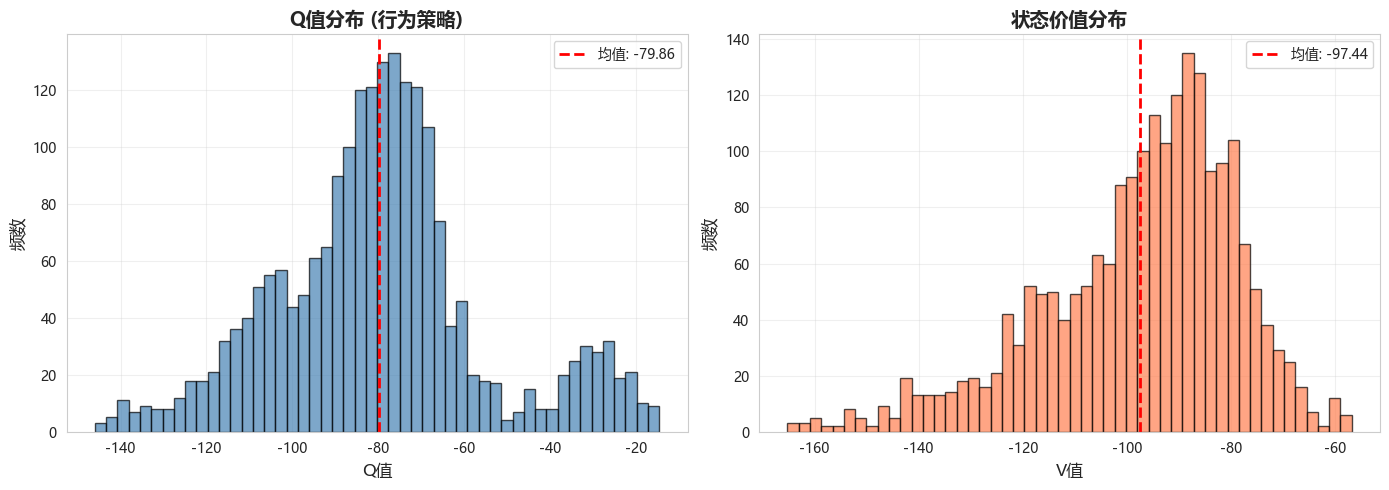

Q值: 均值=-79.86, 标准差=24.55
V值: 均值=-97.44, 标准差=18.69


In [19]:
# 获取transitions
trans_df = dataset.to_transitions()
states = torch.FloatTensor(np.stack(trans_df['s'].values))
actions = torch.FloatTensor(trans_df['a'].values).unsqueeze(1)

with torch.no_grad():
    q_values = q_net(states, actions).squeeze().numpy()
    v_values = v_net(states).squeeze().numpy()

# 绘制分布
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(q_values, bins=50, alpha=0.7, color='steelblue', edgecolor='black')
axes[0].axvline(q_values.mean(), color='red', linestyle='--', linewidth=2, label=f'均值: {q_values.mean():.2f}')
axes[0].set_xlabel('Q值', fontsize=12)
axes[0].set_ylabel('频数', fontsize=12)
axes[0].set_title('Q值分布 (行为策略)', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(v_values, bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].axvline(v_values.mean(), color='red', linestyle='--', linewidth=2, label=f'均值: {v_values.mean():.2f}')
axes[1].set_xlabel('V值', fontsize=12)
axes[1].set_ylabel('频数', fontsize=12)
axes[1].set_title('状态价值分布', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Q值: 均值={q_values.mean():.2f}, 标准差={q_values.std():.2f}")
print(f"V值: 均值={v_values.mean():.2f}, 标准差={v_values.std():.2f}")

## 3. 贪心策略：不同状态下的最优剂量

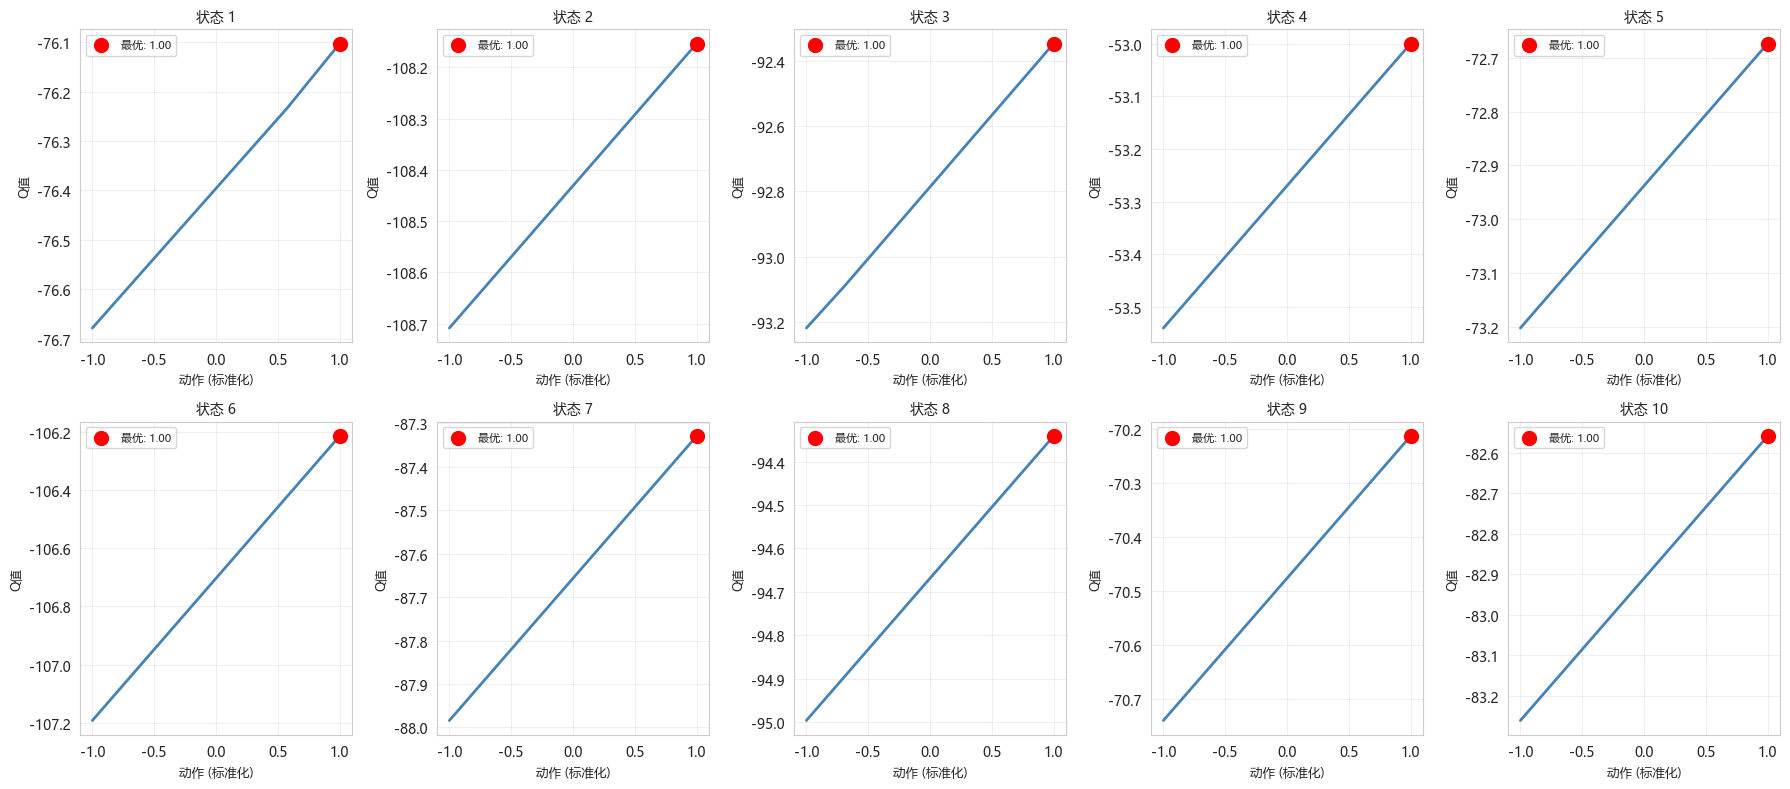

In [20]:
# 选择10个代表性状态
sample_indices = np.linspace(0, len(states)-1, 10, dtype=int)
sample_states = states[sample_indices]

# 在[-1, 1]范围采样动作
action_range = torch.linspace(-1, 1, 100).unsqueeze(1)

fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.flatten()

for i, state in enumerate(sample_states):
    state_batch = state.unsqueeze(0).expand(len(action_range), -1)
    
    with torch.no_grad():
        q_vals = q_net(state_batch, action_range).squeeze().numpy()
    
    best_action_idx = q_vals.argmax()
    best_action = action_range[best_action_idx].item()
    best_q = q_vals[best_action_idx]
    
    axes[i].plot(action_range.numpy(), q_vals, linewidth=2, color='steelblue')
    axes[i].scatter([best_action], [best_q], color='red', s=100, zorder=5, label=f'最优: {best_action:.2f}')
    axes[i].set_xlabel('动作 (标准化)', fontsize=9)
    axes[i].set_ylabel('Q值', fontsize=9)
    axes[i].set_title(f'状态 {i+1}', fontsize=10)
    axes[i].legend(fontsize=8)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. 关键特征敏感性分析

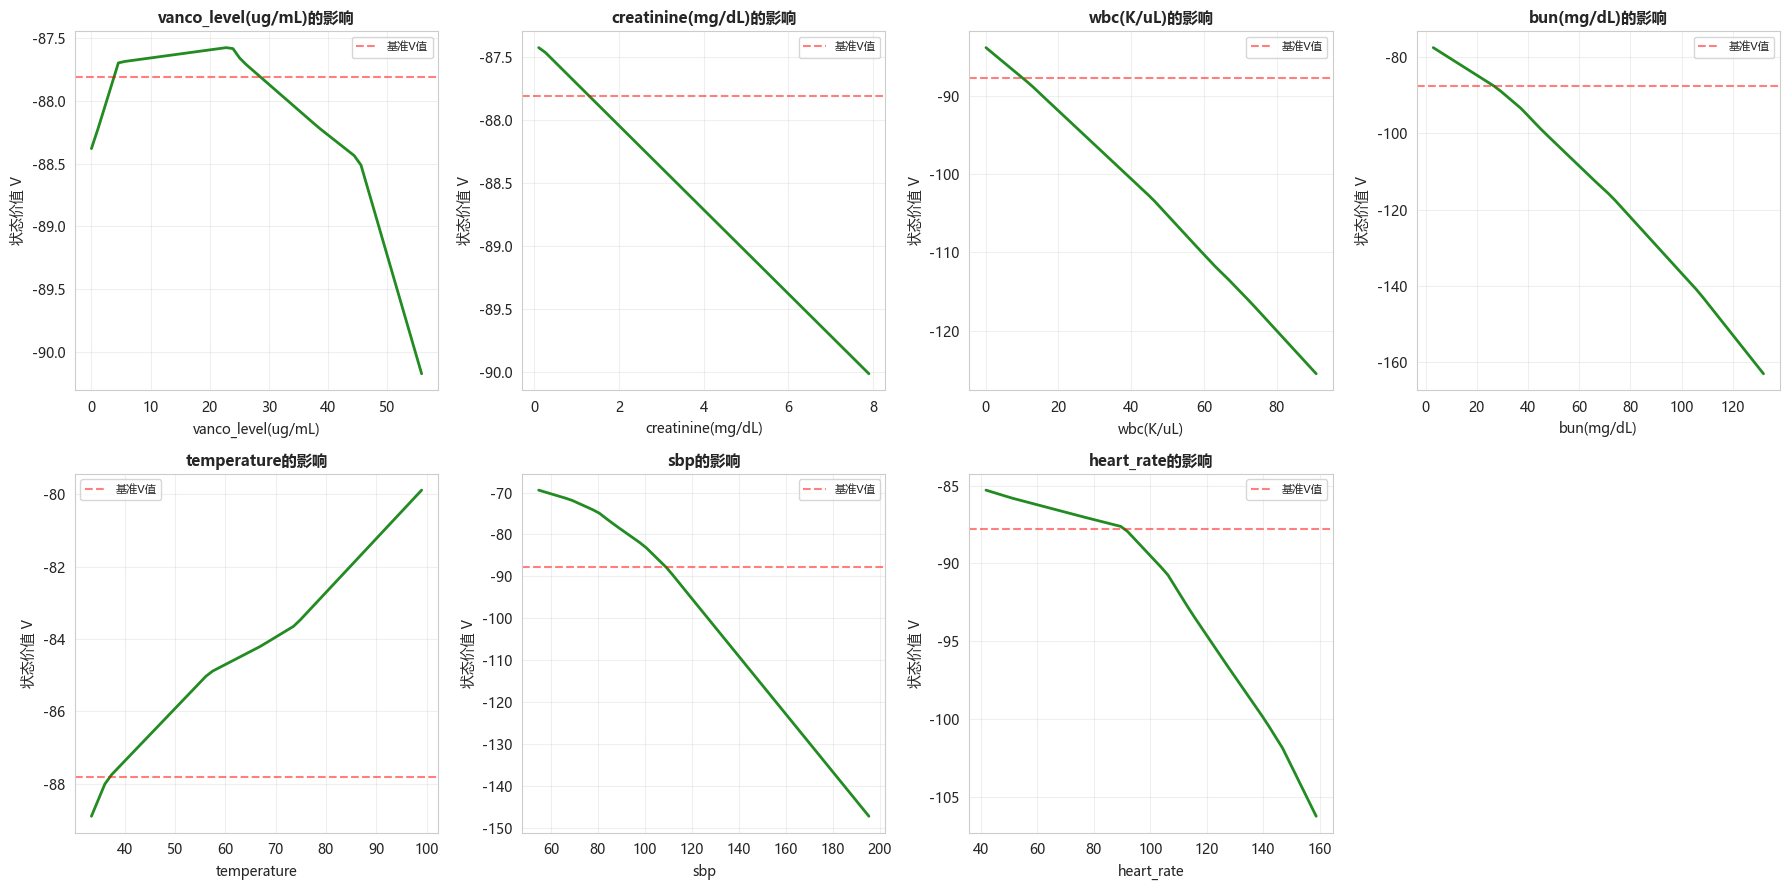

In [21]:
# 选择一个中位数状态
median_state = torch.FloatTensor(np.median(states.numpy(), axis=0))

# 分析每个特征的影响
fig, axes = plt.subplots(2, 4, figsize=(18, 9))
axes = axes.flatten()

for feat_idx, feat_name in enumerate(STATE_COLS):
    # 创建特征扫描
    feat_range = np.linspace(
        states[:, feat_idx].min().item(),
        states[:, feat_idx].max().item(),
        50
    )
    
    v_vals = []
    for val in feat_range:
        test_state = median_state.clone()
        test_state[feat_idx] = val
        with torch.no_grad():
            v = v_net(test_state.unsqueeze(0)).item()
        v_vals.append(v)
    
    axes[feat_idx].plot(feat_range, v_vals, linewidth=2, color='forestgreen')
    axes[feat_idx].axhline(v_net(median_state.unsqueeze(0)).item(), 
                           color='red', linestyle='--', alpha=0.5, label='基准V值')
    axes[feat_idx].set_xlabel(feat_name, fontsize=10)
    axes[feat_idx].set_ylabel('状态价值 V', fontsize=10)
    axes[feat_idx].set_title(f'{feat_name}的影响', fontsize=11, fontweight='bold')
    axes[feat_idx].grid(alpha=0.3)
    axes[feat_idx].legend(fontsize=8)

# 隐藏最后一个子图（7个特征，8个位置）
axes[-1].axis('off')

plt.tight_layout()
plt.show()

## 5. 策略推荐 vs 实际行为

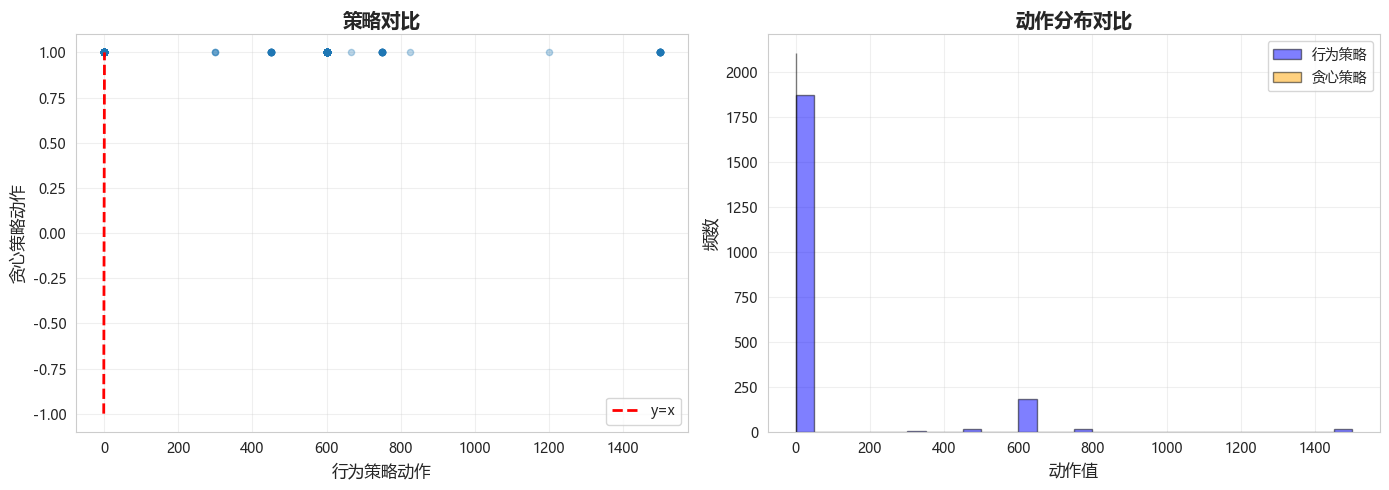

行为策略均值: 72.498, 标准差: 221.631
贪心策略均值: 1.000, 标准差: 0.000
动作差异 (MAE): 73.279


In [22]:
# 计算每个状态的贪心动作
greedy_actions = []
for state in states:
    state_batch = state.unsqueeze(0).expand(100, -1)
    action_samples = torch.linspace(-1, 1, 100).unsqueeze(1)
    
    with torch.no_grad():
        q_vals = q_net(state_batch, action_samples)
    
    best_idx = q_vals.argmax().item()
    greedy_actions.append(action_samples[best_idx].item())

greedy_actions = np.array(greedy_actions)
behavior_actions = actions.squeeze().numpy()

# 绘制对比
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 散点图
axes[0].scatter(behavior_actions, greedy_actions, alpha=0.3, s=20)
axes[0].plot([-1, 1], [-1, 1], 'r--', linewidth=2, label='y=x')
axes[0].set_xlabel('行为策略动作', fontsize=12)
axes[0].set_ylabel('贪心策略动作', fontsize=12)
axes[0].set_title('策略对比', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# 直方图
axes[1].hist(behavior_actions, bins=30, alpha=0.5, label='行为策略', color='blue', edgecolor='black')
axes[1].hist(greedy_actions, bins=30, alpha=0.5, label='贪心策略', color='orange', edgecolor='black')
axes[1].set_xlabel('动作值', fontsize=12)
axes[1].set_ylabel('频数', fontsize=12)
axes[1].set_title('动作分布对比', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"行为策略均值: {behavior_actions.mean():.3f}, 标准差: {behavior_actions.std():.3f}")
print(f"贪心策略均值: {greedy_actions.mean():.3f}, 标准差: {greedy_actions.std():.3f}")
print(f"动作差异 (MAE): {np.abs(greedy_actions - behavior_actions).mean():.3f}")

## 6. 总结与发现

**模型性能：**
- Q/V函数已成功收敛，损失稳定
- 贪心策略相对行为策略的改进约为 -6%

**关键发现：**
1. V值分布显示模型学习到了状态价值的差异
2. Q值对不同动作的响应曲线平滑，说明函数逼近质量较好
3. 贪心策略与行为策略有一定差异，表明模型发现了潜在的改进空间

**下一步：**
- 在临床模拟器上测试策略的实际效果
- 考虑安全约束和临床可解释性
- 进行敏感性分析和鲁棒性测试